# Test different interpolations

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
# fake beta function
def special_beta(alpha, beta): return special.gamma(alpha)*special.gamma(beta)/special.gamma(alpha+beta)

In [2]:
import eko.dglap as dglap
import eko.interpolation as interpolation
import eko.mellin as mellin

In [3]:
def get_toy_pdf_x(alpha, beta):
    """test fnc in x"""
    return lambda x,alpha=alpha,beta=beta: x**alpha * (1-x)**beta
def get_toy_pdf_N(alpha, beta):
    return lambda N: special_beta(N+alpha,beta+1)

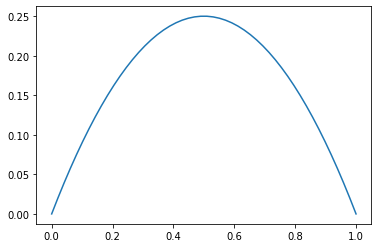

In [4]:
xs = np.linspace(0,1)
ys = get_toy_pdf_x(1,1)(xs)
plt.plot(xs,ys)
plt.show()

In [5]:
def get_linear_interpolators_x(x,xgrid,j):
    """get j-th linear interpolator of grid"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    if 0 == j: return (xgrid[1]-x)/(xgrid[1]) if x <= xgrid[1] else 0.
    if l - 1 == j: return (x-xgrid[-2])/(xgrid[-1] - xgrid[-2]) if x >= xgrid[-2] else 0.
    if (xgrid[j]-x)*(x-xgrid[j-1]) > 0:
        return (x-xgrid[j-1])/(xgrid[j]-xgrid[j-1])
    if (xgrid[j]-x)*(x-xgrid[j+1]) >= 0:
        return (xgrid[j+1]-x)/(xgrid[j+1]-xgrid[j])
    return 0.

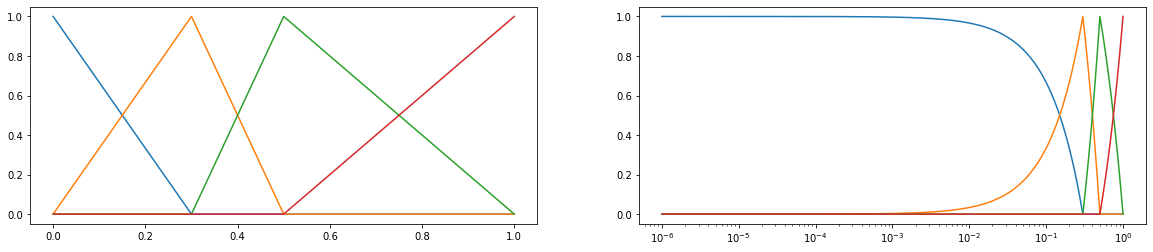

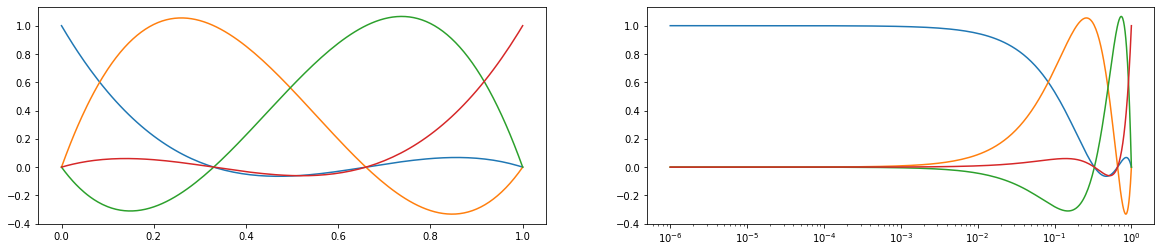

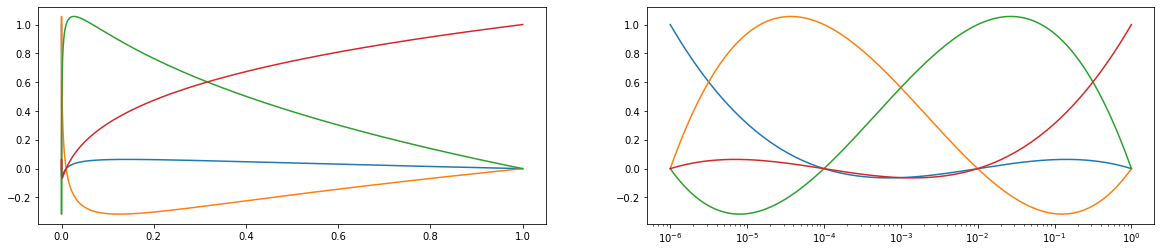

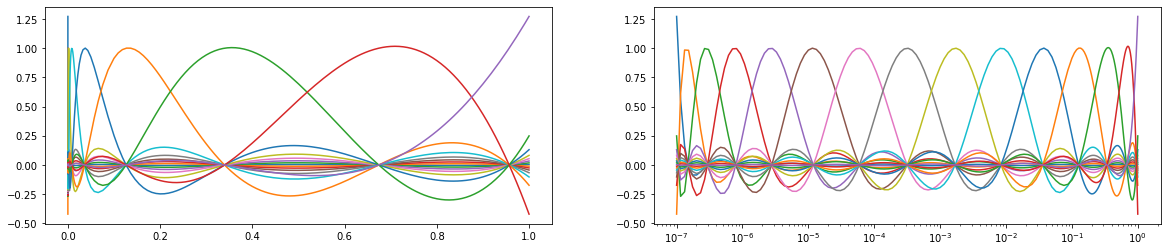

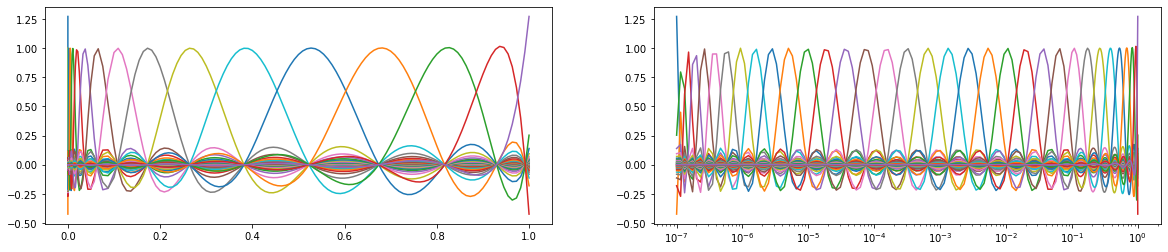

In [9]:
def plot_interpolators_x(f,g,xmin=1e-6):
    """plot all linear interpolators of grid"""
    xs = np.append(np.logspace(np.log10(xmin),-1,num=100),np.linspace(0.1,1.,num=100))
    plt.figure(figsize=(20,4))
    plt.title("all interpolators p_j(x)")
    plt.subplot(1,2,1)
    for j in range(len(g)):
        ys = [f(x,g,j) for x in xs]
        plt.plot(xs,ys)
    plt.subplot(1,2,2)
    for j in range(len(g)):
        ys = [f(x,g,j) for x in xs]
        plt.semilogx(xs,ys)
    plt.show()

plot_interpolators_x(get_linear_interpolators_x,[0.,.3,.5,1.])
plot_interpolators_x(interpolation.get_Lagrange_interpolators_x,[0.,.33,.66,1.])
plot_interpolators_x(interpolation.get_Lagrange_interpolators_log_x,[1e-6,1e-4,1e-2,1.])
plot_interpolators_x(interpolation.get_Lagrange_interpolators_log_x,interpolation.get_xgrid_Chebyshev_at_log(15,1e-7),1e-7)
plot_interpolators_x(interpolation.get_Lagrange_interpolators_log_x,interpolation.get_xgrid_Chebyshev_at_log(35,1e-7),1e-7)

In [33]:
def plot_dist(x,y,yref,title=None):
    """compare to distributions both in linear and logarithmic x-space"""
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(hspace=0.05)
    if title is not None:
       fig.suptitle(title)
    # small x
    ax1 = plt.subplot(2,3,1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.title("small x")
    plt.loglog(x,y,"o")
    plt.loglog(x,yref,"x")
    plt.subplot(2,3,4,sharex=ax1)
    plt.loglog(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # linear x
    ax2 = plt.subplot(2,3,2)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.title("linear x")
    plt.plot(x,y,"o")
    plt.plot(x,yref,"x")
    plt.subplot(2,3,5,sharex=ax2)
    plt.semilogy(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # large x
    ax3 = plt.subplot(2,3,3)
    oMx = 1.0 - x
    plt.setp(ax3.get_xticklabels(), visible=False)
    oMx_min = 1e-2
    oMx_max = 0.5
    ax3.set_xlim(oMx_min,oMx_max)
    plt.title("large x, i.e. small (1-x)")
    plt.loglog(oMx,y,"o")
    plt.loglog(oMx,yref,"x")
    ax = plt.subplot(2,3,6,sharex=ax3)
    plt.loglog(oMx,np.abs((y - yref)/yref),"x")
    plt.xlabel("1-x")
    return fig

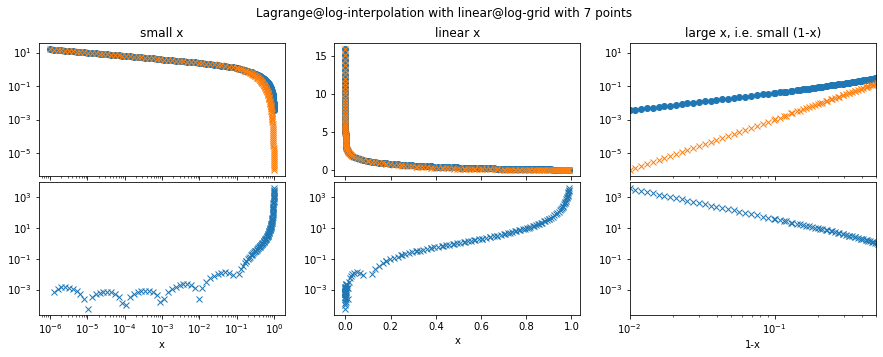

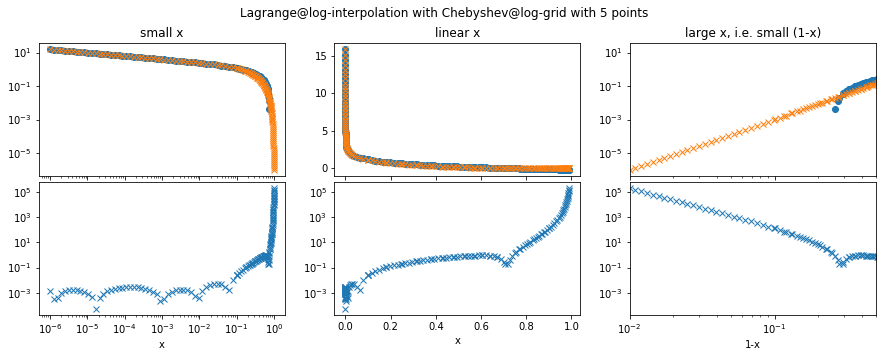

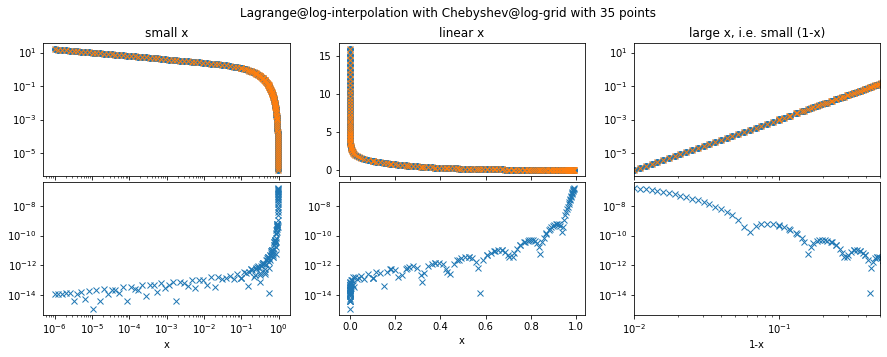

In [34]:
def test_interpolation_x(f,p,g,xmin=1e-6,title=None):
    """plots interpolation vs real thing in x"""
    fs = [f(x) for x in g]
    fp = lambda y,g=g,fs=fs: np.sum([fs[j]*p(y,g,j) for j in range(len(g))])

    oMx = 1.0 - np.logspace(-2,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    yref = np.array([f(x) for x in xs])
    y = np.array([fp(x) for x in xs])

    return plot_dist(xs,y,yref,title=title)

toy_alpha = -.2
toy_beta = 3.
#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_linear_interpolators_x, [.01,.3,.5,1.], title="linear interpolation in x with custom grid")

#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_x, [.1,.3,.5,.8,1.], title="Lagrange interpolation in x with custom grid")

fig = test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_log_x, interpolation.get_xgrid_linear_at_log(7,1e-6),title="Lagrange@log-interpolation with linear@log-grid with 7 points")

test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_log_x, interpolation.get_xgrid_Chebyshev_at_log(5,1e-6),title="Lagrange@log-interpolation with Chebyshev@log-grid with 5 points")

test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_log_x, interpolation.get_xgrid_Chebyshev_at_log(35,1e-6),title="Lagrange@log-interpolation with Chebyshev@log-grid with 35 points");

In [15]:
# test Mellin transformation on toy_pdf
toy_alpha = 2.3
toy_beta = .5
for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
    e = get_toy_pdf_N(toy_alpha,toy_beta)(c)
    i,ie = mellin.mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),c)
    print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (0.06506938494905695-0.046801971951956206j) , int =  (0.0650693849441131-0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.06506938494905695+0.046801971951956206j) , int =  (0.0650693849441131+0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.041834527464115055-0.21549284638271926j) , int =  (0.041834527409332224-0.21549284630671234j) , |rel_err| =  4.268121107916933e-10


In [16]:
# test Mellin transformation on get_Lagrange_interpolators_x|N
g = [0.,.5,1.]
for k in range(len(g)):
    for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
        e = interpolation.get_Lagrange_interpolators_N(c,g,k)
        i,ie = mellin.mellin_transform(lambda x: interpolation.get_Lagrange_interpolators_x(x,g,k),c)
        print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

exact =  (-0.04230769230769227+0.011538461538461553j) , int =  (-0.042307691866726164+0.011538461538452381j) , |rel_err| =  1.0055574301762228e-08
exact =  (-0.04230769230769227-0.011538461538461553j) , int =  (-0.042307691866726164-0.011538461538452381j) , |rel_err| =  1.0055574301762228e-08
exact =  (0.2+0.30000000000000004j) , int =  (0.19999999975547797+0.29999999959768586j) , |rel_err| =  1.3057497987283011e-09
exact =  (0.12307692307692308-0.2153846153846154j) , int =  (0.12307692307791729-0.2153846153792987j) , |rel_err| =  2.180376900395882e-11
exact =  (0.12307692307692308+0.2153846153846154j) , int =  (0.12307692307791729+0.2153846153792987j) , |rel_err| =  2.180376900395882e-11
exact =  (-0.8-0.3999999999999999j) , int =  (-0.8000000000000056-0.3999999999999926j) , |rel_err| =  1.0277811322930146e-14
exact =  (0.16923076923076924-0.046153846153846156j) , int =  (0.16923076924086644-0.04615384615517567j) , |rel_err| =  5.805975165046727e-11
exact =  (0.16923076923076924+0.046

In [49]:
# test Mellin transformation on get_Lagrange_interpolators_log_x|N
g = [1e-4,1e-2,1.]
g = interpolation.get_xgrid_Chebyshev_at_log(15,1e-7)
for k in range(len(g)):
    for c in [1,2,3,np.complex(2,2),np.complex(2,-2)]: #,np.complex(-2,-2)]: for negative real parts, integration breaks ...
        e = interpolation.get_Lagrange_interpolators_log_N(c,g,k)
        i,ie = mellin.mellin_transform(lambda x: interpolation.get_Lagrange_interpolators_log_x(x,g,k),c)
        print(f"polynom #{k} at c={c}: exact = {e:.3e}, int = ({i:.3e})+-({ie:.3e}), |rel_err| = ",np.abs((e-i)/e))

/home/felix/Physik/N3PDF/EKO/eko/src/eko/mellin.py:180: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  r, re = integrate.quad(lambda x: np.real(integrand(x)), 0, 1)
polynom #0 at c=1: exact = 2.273e-04, int = (-1.418e-04+0.000e+00j)+-(1.961e-08+0.000e+00j), |rel_err| =  1.6241306035545886
polynom #0 at c=2: exact = -1.716e-04, int = (-1.716e-04+0.000e+00j)+-(5.040e-09+0.000e+00j), |rel_err| =  3.856669282954467e-07
polynom #0 at c=3: exact = -1.986e-04, int = (-1.986e-04+0.000e+00j)+-(2.800e-09+0.000e+00j), |rel_err| =  6.034202560697842e-09
polynom #0 at c=(2+2j): exact = -2.289e-04-1.385e-04j, int = (-2.289e-04-1.385e-04j)+-(5.180e-09+3.976e-09j), |rel_err| =  1.4404820100020062e-06
polynom #0 at c=(2-2j): exact = -2.289e-04+1.385e-04j, int = (-2.289e-04+1.385e-04j)+-(5.180e-09+3.976e-09j), |rel_err| =  1.4404820100020062e-06
polynom #1 at c=1: exact = -6.105e-04, int = (4.286e-04+0.000e+00j)+-(4.740e-08+0.000e+00j), |rel_err| =  1.7020296260847165
po

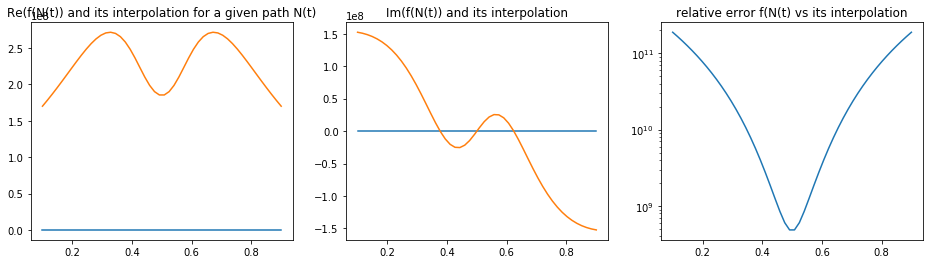

In [44]:
def test_interpolation_N(fx,fN,pN,g,path,ts = np.linspace(0,1)):
    """plots interpolation to real thing in x"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    fig = plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("Re(f(N(t)) and its interpolation for a given path N(t)")
    ys = [fN(path(t)) for t in ts]
    yps = [fNp(path(t)) for t in ts]
    plt.plot(ts,np.real(ys))
    plt.plot(ts,np.real(yps))
    plt.subplot(1,3,2)
    plt.title("Im(f(N(t)) and its interpolation")
    plt.plot(ts,np.imag(ys))
    plt.plot(ts,np.imag(yps))
    plt.subplot(1,3,3)
    plt.title("relative error f(N(t) vs its interpolation")
    plt.semilogy(ts,[np.abs((ys[j] - yps[j])/ys[j]) for j in range(len(xs))])
    plt.show()
    return fig

toy_alpha = -0.2
toy_beta = 3.0
#g = np.linspace(0,1,num=5)
g = interpolation.get_xgrid_Chebyshev_at_log(5,1e-6)
path,jac = mellin.get_path_line(10)
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta), get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_N,
                    g,
                    path,np.linspace(.1,.9)
                    );

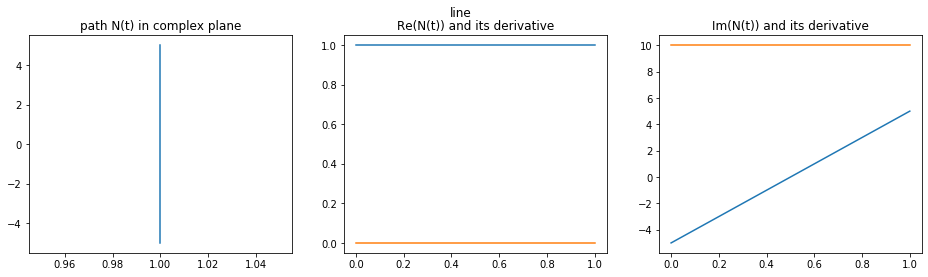

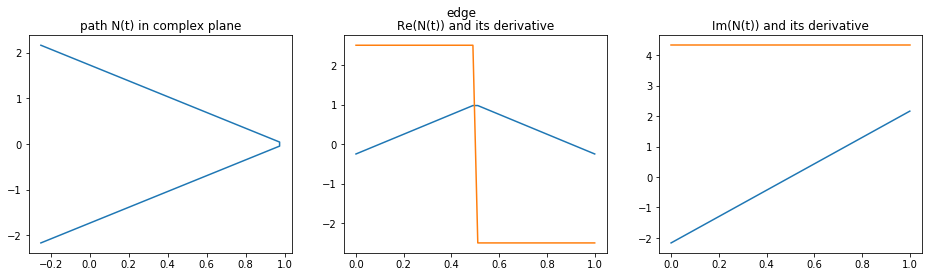

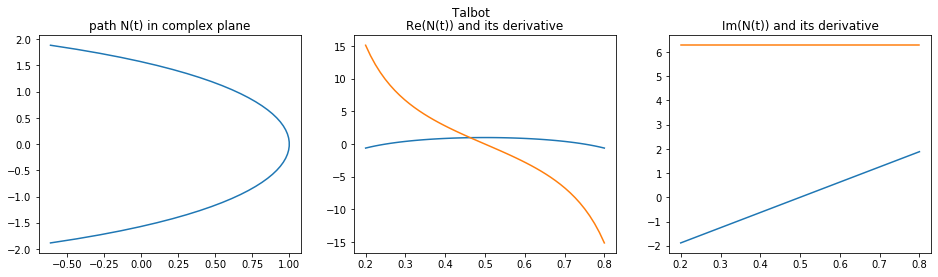

In [17]:
def plot_path(path,jac,plot_ts = np.linspace(0.,1)):
    fig = plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("path N(t) in complex plane")
    ps = [path(t) for t in plot_ts]
    plt.plot(np.real(ps),np.imag(ps))
    plt.subplot(1,3,2)
    plt.title("Re(N(t)) and its derivative")
    pds = [jac(t) for t in plot_ts]
    plt.plot(plot_ts,np.real(ps))
    plt.plot(plot_ts,np.real(pds))
    plt.subplot(1,3,3)
    plt.title("Im(N(t)) and its derivative")
    plt.plot(plot_ts,np.imag(ps))
    plt.plot(plot_ts,np.imag(pds))
    return fig

p,j = mellin.get_path_line(5)
fig = plot_path(p,j)
fig.suptitle("line")

p,j = mellin.get_path_edge(5)
fig = plot_path(p,j)
fig.suptitle("edge")

p,j = mellin.get_path_Talbot()
fig = plot_path(p,j,np.linspace(.2,.8))
fig.suptitle("Talbot");

/home/felix/Physik/N3PDF/EKO/eko/src/eko/mellin.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(integrand, cut, 1.0 - cut)


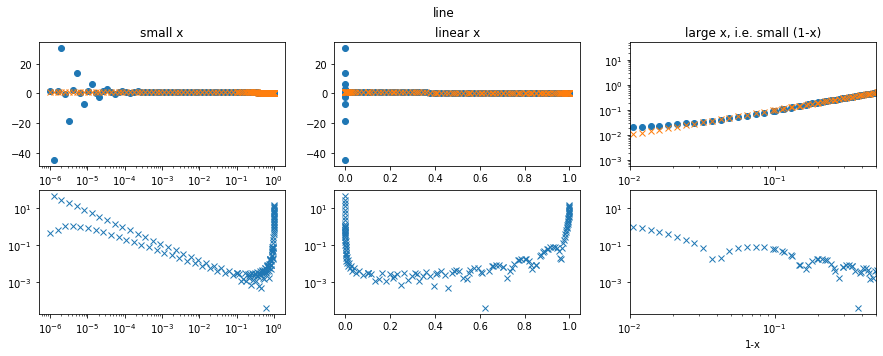

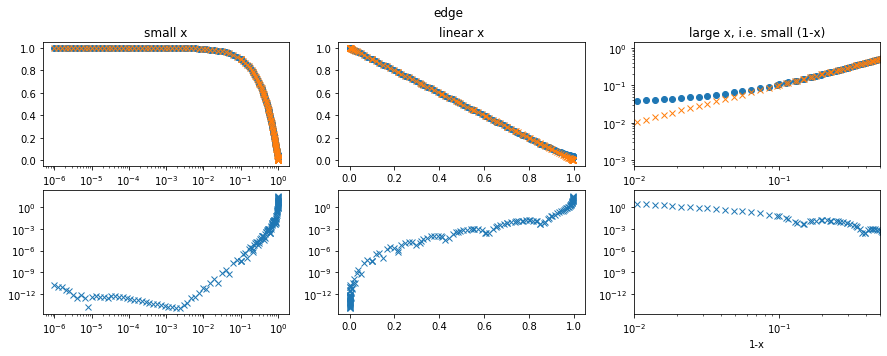

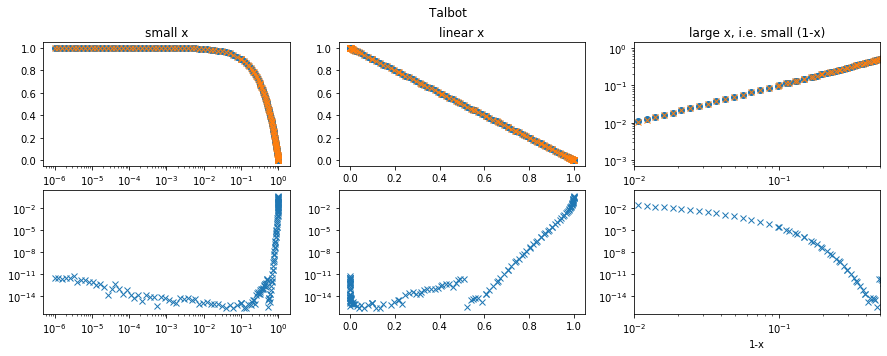

In [19]:
def test_inverse_Mellin_transform(fx,fN,path,jac,cut=0.,xmin=1e-6):
    """plot Mellin integration path and compare numeric inversion to real thing"""
    oMx = 1.0 - np.logspace(-3,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    ys = [fx(x) for x in xs]
    yps = [mellin.inverse_mellin_transform(fN,path,jac,x,cut) for x in xs]
    if isinstance(yps[0],tuple):
        yps = [yp[0] for yp in yps]

    return plot_dist(xs,np.array(yps),np.array(ys))

toy_alpha = 0
toy_beta = 1
p,j = mellin.get_path_line(20)
fig = test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
fig.suptitle("line")

p,j = mellin.get_path_edge(20)
fig = test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
fig.suptitle("edge")

p,j = mellin.get_path_Talbot()
fig = test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j,1e-2)
fig.suptitle("Talbot");

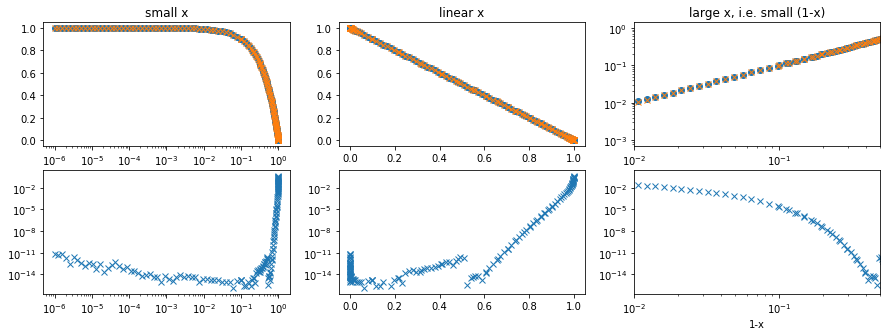

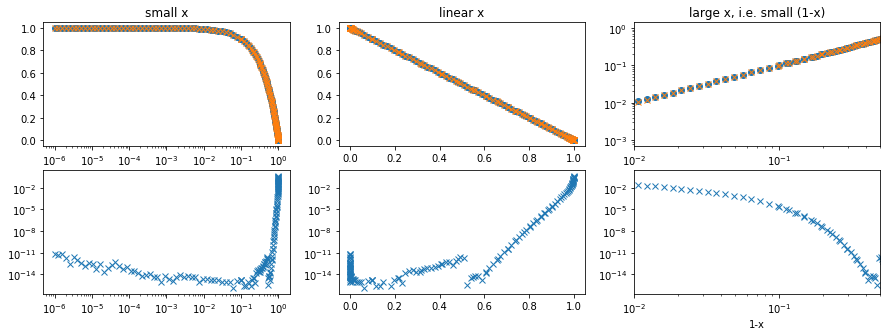

In [20]:
def test_inv_interpolation_x(fx,pN,g,path,jac,cut=0.):
    """compare interpolated numeric inversion to real thing"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,pN=pN,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    return test_inverse_Mellin_transform(fx,fNp,path,jac,cut)

p,j = mellin.get_path_Talbot()
test_inv_interpolation_x(get_toy_pdf_x(0.,1.),
                     interpolation.get_Lagrange_interpolators_N,
                     [0.,.5,1.],
                     p,j,1e-2
                     )

[0.01253604390908819, 0.1090842587659851, 0.2830581304412209, 0.49999999999999994, 0.716941869558779, 0.890915741234015, 0.9874639560909118]


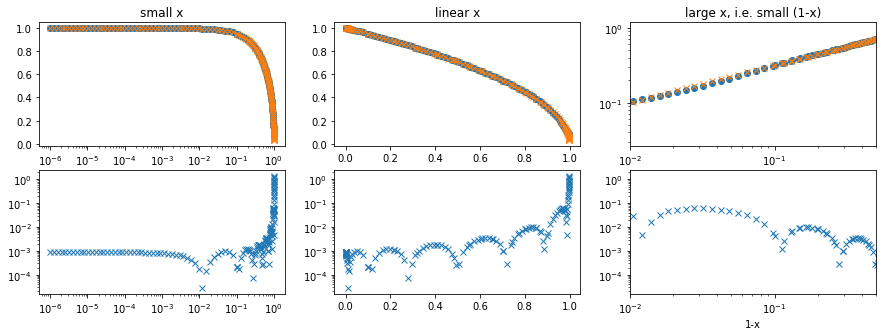

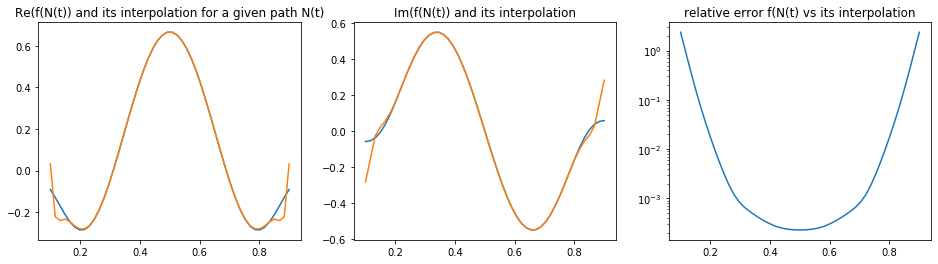

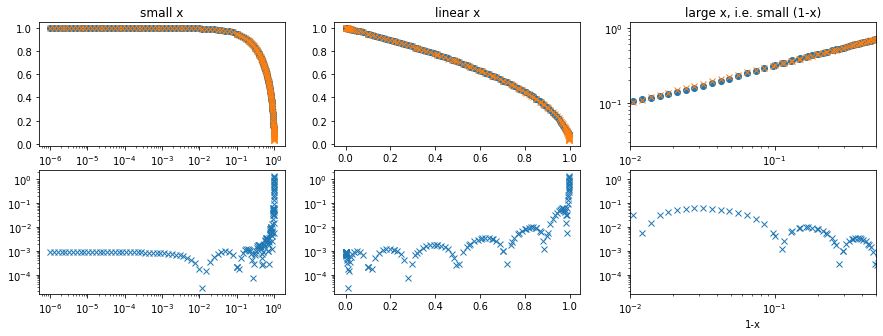

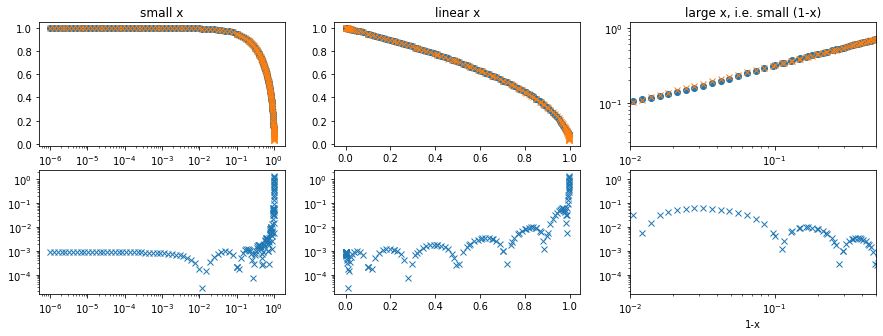

In [21]:
toy_alpha = 0.
toy_beta = .5
#g = np.linspace(0.,1.,num=7)
n_points = 7
g = [.5 - .5*np.cos((2.*j+1)/(2.*n_points)*np.pi) for j in range(n_points)]
print(g)
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_x,
                    g)
p,j = mellin.get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         interpolation.get_Lagrange_interpolators_N,
                         g,
                         p,j,
                         1e-2
                        )

[1.189094207336904e-06, 4.513417958554193e-06, 4.992853033786162e-05, 0.000999999999999999, 0.020028628786649537, 0.2215615768765043, 0.8409762606106714]


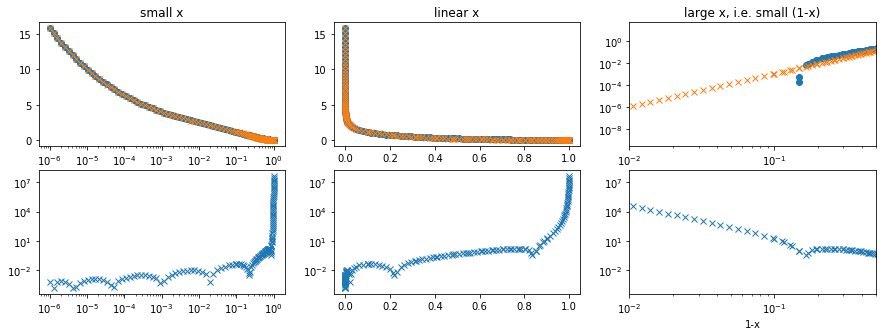

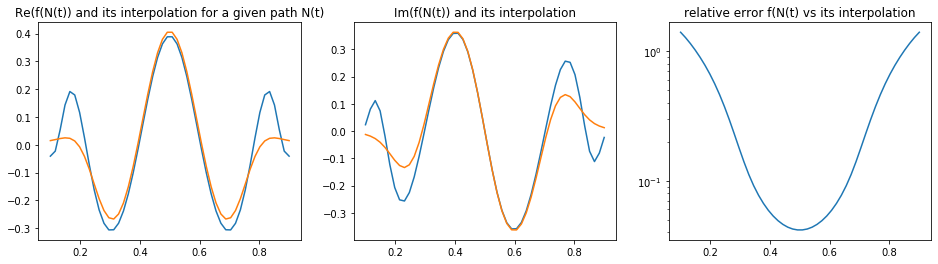

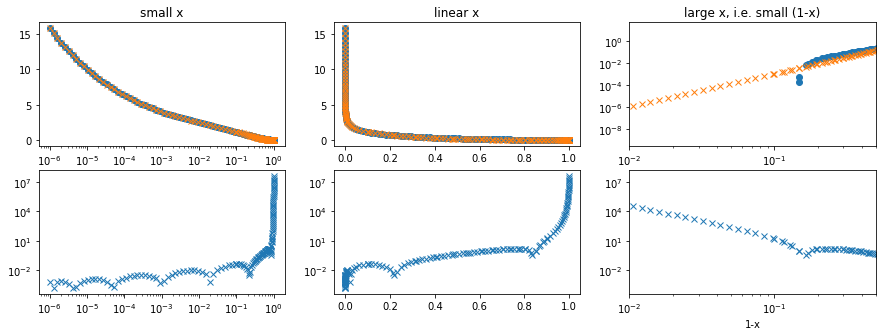

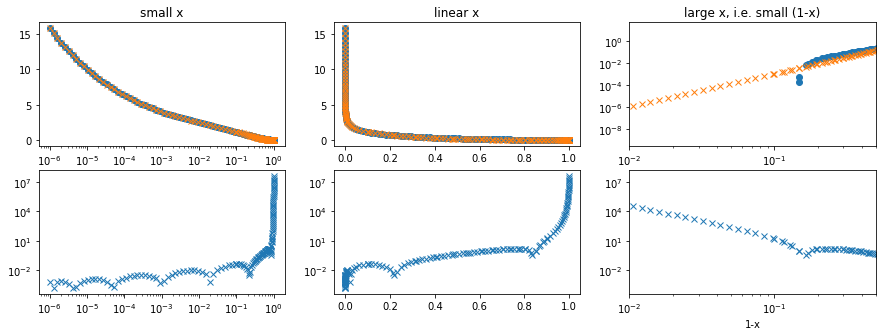

In [22]:
toy_alpha = -0.2
toy_beta = 3.
n_points = 7
g = interpolation.get_xgrid_Chebyshev_at_log(n_points,1e-6)
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_log_x,
                    g)
#p,j = get_path_line(10)
p,j = mellin.get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_log_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         interpolation.get_Lagrange_interpolators_log_N,
                         g,
                         p,j,
                         1e-2
                        )